参考文献: <https://qiita.com/cvusk/items/61cdbce80785eaf28349>

In [1]:
import os
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import model_selection
from sklearn import preprocessing
import IPython.display as ipd

In [2]:
base_dir = "./"
# directory for ESC-50 dataset
esc_dir = os.path.join(base_dir, "ESC-50-master")
meta_file = os.path.join(esc_dir, "meta/esc50.csv")
audio_dir = os.path.join(esc_dir, "audio/")

meta_data = pd.read_csv(meta_file)
data_size = meta_data.shape
print(data_size)

class_dict = {}

# Extracting categories loop
# data_size[0] is the number of data(number of rows in csv)
for i in range(data_size[0]):
    if meta_data.loc[i, "target"] not in class_dict.keys():
        class_dict[meta_data.loc[i, "target"]] = meta_data.loc[i, "category"]

(2000, 7)


wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


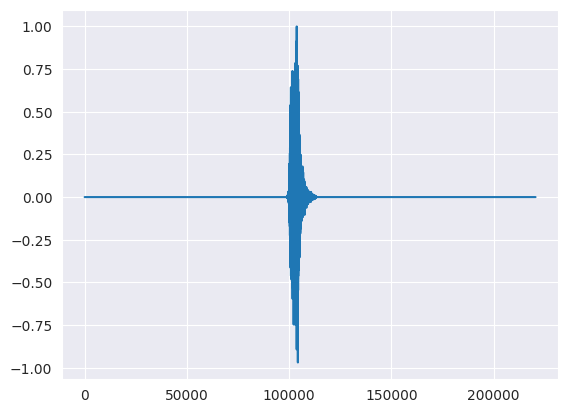

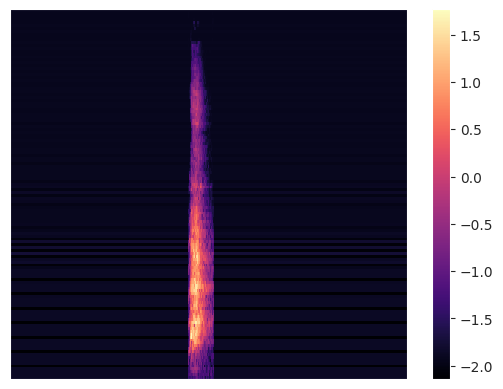

In [3]:
def load_wave_data(audio_dir, file_name):
    file_path = os.path.join(audio_dir, file_name)
    x, fs = librosa.load(file_path, sr=44100)
    return x, fs

def calculate_melsp(x, n_fft=1026, hop_length=128):
    """
    stft is Short-Time Fourier Transform
    This expression computes the power spectrogram of the audio signal.
    n_fft: size of FFT window
    hop_length:
    """
    stft = np.abs(librosa.stft(x, n_fft = n_fft, hop_length = hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S = log_stft, n_mels = 128)
    return melsp

def show_wave(x):
    plt.plot(x)
    plt.show()

def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, sr=fs)
    plt.colorbar()
    plt.show()

x, fs = load_wave_data(audio_dir, meta_data.loc[0,"filename"])
melsp = calculate_melsp(x)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x.shape, melsp.shape, fs))
show_wave(x)
show_melsp(melsp, fs)

In [4]:
# data augmentation: add white noise
def add_white_noise(x, rate=0.002):
    return x + rate*np.random.randn(len(x))

# data augmentation: shift sound in timeframe
def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

# data augmentation: stretch sound
def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(x, rate = rate)
    if len(x)>input_length:
        return x[:input_length]
    else:
        return np.pad(x, (0, max(0, input_length - len(x))), "constant")

In [5]:
import librosa
import librosa.display

# change wave data to mel-stft
def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=128)
    return melsp

In [6]:
# get training dataset and target dataset
x = list(meta_data.loc[:,"filename"])
y = list(meta_data.loc[:, "target"])

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.25, stratify=y)
print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(len(x_train),
                                                                len(y_train),
                                                                len(x_test),
                                                                len(y_test)))

"""output
x train:1500
y train:1500
x test:500
y test:500
"""

# showing the classes are equally splitted
a = np.zeros(50)
for c in y_test:
    a[c] += 1
print(a)

"""output
[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
"""

x train:1500
y train:1500
x test:500
y test:500
[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


'output\n[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.\n 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.\n 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]\n'

In [7]:
freq = 128
time = 1723

# save wave data in npz, with augmentation
def save_np_data(filename, x, y, aug=None, rates=None):
    np_data = np.zeros(freq*time*len(x)).reshape(len(x), freq, time)
    np_targets = np.zeros(len(y))
    for i in range(len(y)):
        _x, fs = load_wave_data(audio_dir, x[i])
        if aug is not None:
            _x = aug(x=_x, rate=rates[i])
        _x = calculate_melsp(_x)
        np_data[i] = _x
        np_targets[i] = y[i]
    np.savez(filename, x=np_data, y=np_targets)

In [8]:
# save test dataset
if not os.path.exists("esc_melsp_test.npz"):
    save_np_data("esc_melsp_test.npz", x_test,  y_test)

In [9]:
# save raw training dataset
if not os.path.exists("esc_melsp_train_raw.npz"):
    save_np_data("esc_melsp_train_raw.npz", x_train,  y_train)

In [10]:
# save training dataset with white noise
if not os.path.exists("esc_melsp_train_wn.npz"):
    rates = np.random.randint(1,50,len(x_train))/10000
    save_np_data("esc_melsp_train_wn.npz", x_train,  y_train, aug=add_white_noise, rates=rates)

In [11]:
# save training dataset with sound shift
if not os.path.exists("esc_melsp_train_ss.npz"):
    rates = np.random.choice(np.arange(2,6),len(y_train))
    save_np_data("esc_melsp_train_ss.npz", x_train,  y_train, aug=shift_sound, rates=rates)

In [12]:
# save training dataset with stretch
if not os.path.exists("esc_melsp_train_st.npz"):
    rates = np.random.choice(np.arange(80,120),len(y_train))/100
    save_np_data("esc_melsp_train_st.npz", x_train,  y_train, aug=stretch_sound, rates=rates)

In [13]:
# save training dataset with combination of white noise and shift or stretch
if not os.path.exists("esc_melsp_train_com.npz"):
    np_data = np.zeros(freq*time*len(x_train)).reshape(len(x_train), freq, time)
    np_targets = np.zeros(len(y_train))
    for i in range(len(y_train)):
        x, fs = load_wave_data(audio_dir, x_train[i])
        x = add_white_noise(x=x, rate=np.random.randint(1,50)/1000)
        if np.random.choice((True,False)):
            x = shift_sound(x=x, rate=np.random.choice(np.arange(2,6)))
        else:
            x = stretch_sound(x=x, rate=np.random.choice(np.arange(80,120))/100)
        x = calculate_melsp(x)
        np_data[i] = x
        np_targets[i] = y_train[i]
    np.savez("esc_melsp_train_com.npz", x=np_data, y=np_targets)

In [14]:
# PyTorch imports for CNN
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
import torchvision.transforms as transforms

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [15]:
# Improved CNN Model for Audio Classification
class ImprovedAudioCNN(nn.Module):
    def __init__(self, num_classes=50):
        super(ImprovedAudioCNN, self).__init__()

        # More sophisticated convolutional architecture
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(2, 2)

        # Additional convolutional block
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(2, 2)

        # Global Average Pooling instead of flattening
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Improved fully connected layers with better dropout
        self.fc1 = nn.Linear(512, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Convolutional blocks with ReLU activation
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool5(x)

        # Global average pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

# Initialize the improved model
improved_model = ImprovedAudioCNN(num_classes=50).to(device)
print(improved_model)

ImprovedAudioCNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding

In [16]:
# Load pre-prepared datasets
print("Loading pre-prepared datasets...")

# Load training dataset (using combined dataset that includes all augmentations)
train_data = np.load('esc_melsp_train_com.npz')
X_train = train_data['x']
y_train = train_data['y']

# Load test dataset
test_data = np.load('esc_melsp_test.npz')
X_test = test_data['x']
y_test = test_data['y']

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

print("Datasets loaded successfully!")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).unsqueeze(1)  # Add channel dimension
X_test_tensor = torch.FloatTensor(X_test).unsqueeze(1)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")


Loading pre-prepared datasets...
Training data shape: (1500, 128, 1723)
Training labels shape: (1500,)
Test data shape: (500, 128, 1723)
Test labels shape: (500,)
Datasets loaded successfully!
Training batches: 47
Test batches: 16


In [17]:
# Training function
def train_model(model, train_loader, test_loader, num_epochs=50):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total_test += target.size(0)
                correct_test += (predicted == target).sum().item()

        test_accuracy = 100 * correct_test / total_test

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        scheduler.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Train Acc: {train_accuracy:.2f}%, '
                  f'Test Acc: {test_accuracy:.2f}%')

    return train_losses, train_accuracies, test_accuracies

# Train the model
print("Starting training...")
train_losses, train_accuracies, test_accuracies = train_model(improved_model, train_loader, test_loader, num_epochs=50)


Starting training...
Epoch [1/50], Train Loss: 3.9047, Train Acc: 2.47%, Test Acc: 2.00%
Epoch [2/50], Train Loss: 3.7434, Train Acc: 3.53%, Test Acc: 4.80%
Epoch [3/50], Train Loss: 3.6246, Train Acc: 3.93%, Test Acc: 2.40%
Epoch [4/50], Train Loss: 3.5594, Train Acc: 4.73%, Test Acc: 7.80%
Epoch [5/50], Train Loss: 3.4815, Train Acc: 6.73%, Test Acc: 9.80%
Epoch [6/50], Train Loss: 3.3552, Train Acc: 8.07%, Test Acc: 6.80%
Epoch [7/50], Train Loss: 3.2595, Train Acc: 8.20%, Test Acc: 13.20%
Epoch [8/50], Train Loss: 3.1577, Train Acc: 9.40%, Test Acc: 14.40%
Epoch [9/50], Train Loss: 3.0919, Train Acc: 11.33%, Test Acc: 12.60%
Epoch [10/50], Train Loss: 3.0028, Train Acc: 13.60%, Test Acc: 15.40%
Epoch [11/50], Train Loss: 2.9620, Train Acc: 14.53%, Test Acc: 9.60%
Epoch [12/50], Train Loss: 2.8931, Train Acc: 14.07%, Test Acc: 17.40%
Epoch [13/50], Train Loss: 2.8415, Train Acc: 15.53%, Test Acc: 24.40%
Epoch [14/50], Train Loss: 2.7570, Train Acc: 17.00%, Test Acc: 25.40%
Epoch [15

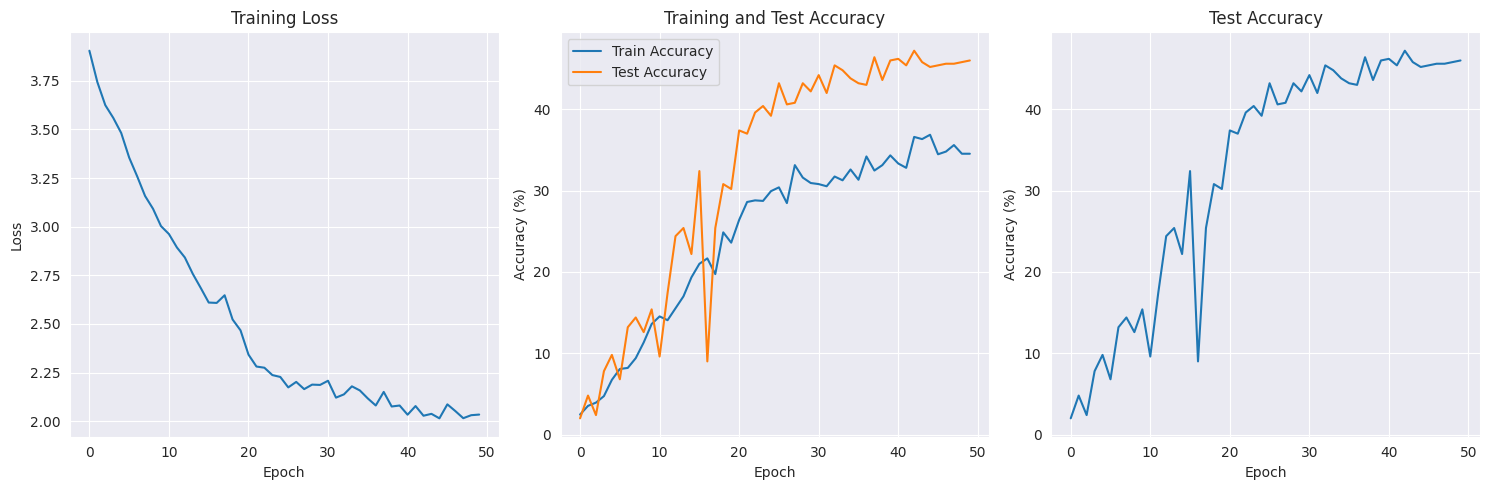

Final Test Accuracy: 46.00%


In [18]:
# Plot training results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")


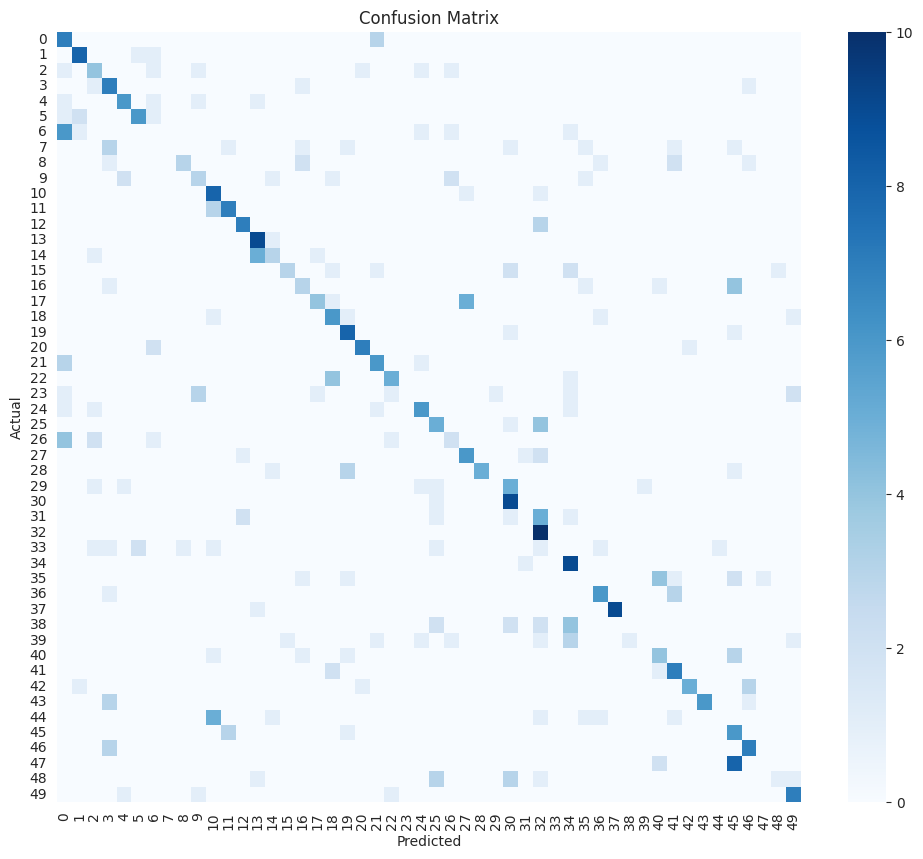


Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.70      0.40        10
           1       0.67      0.80      0.73        10
           2       0.36      0.40      0.38        10
           3       0.35      0.70      0.47        10
           4       0.60      0.60      0.60        10
           5       0.67      0.60      0.63        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.75      0.30      0.43        10
           9       0.33      0.30      0.32        10
          10       0.42      0.80      0.55        10
          11       0.64      0.70      0.67        10
          12       0.70      0.70      0.70        10
          13       0.53      0.90      0.67        10
          14       0.43      0.30      0.35        10
          15       0.75      0.30      0.43        10
          16       0.33      0.30      0.32        10
   

/home/nk21137/PyCharmMiscProject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/nk21137/PyCharmMiscProject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/nk21137/PyCharmMiscProject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

In [19]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions for test set
improved_model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = improved_model(data)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(all_targets, all_predictions)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(all_targets, all_predictions))


In [20]:
# Save the trained model
torch.save(improved_model.state_dict(), 'audio_cnn_model_improved.pth')
print("Model saved as 'audio_cnn_model_improved.pth'")

# Function to load the model
def load_model(model_path):
    model = ImprovedAudioCNN(num_classes=50).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

print("CNN model training complete!")

Model saved as 'audio_cnn_model_improved.pth'
CNN model training complete!


In [21]:
# Advanced training function with improved techniques
def train_model_advanced(model, train_loader, test_loader, num_epochs=100):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing for better generalization

    # Use different optimizers and learning rates
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

    # Cosine annealing scheduler for better convergence
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    # Early stopping parameters
    best_test_acc = 0.0
    patience = 15
    patience_counter = 0

    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            # Apply mixup augmentation occasionally
            if np.random.rand() < 0.3:  # 30% chance of mixup
                lam = np.random.beta(0.2, 0.2)
                index = torch.randperm(data.size(0)).to(device)
                mixed_data = lam * data + (1 - lam) * data[index]
                target_a, target_b = target, target[index]

                optimizer.zero_grad()
                outputs = model(mixed_data)
                loss = lam * criterion(outputs, target_a) + (1 - lam) * criterion(outputs, target_b)
            else:
                optimizer.zero_grad()
                outputs = model(data)
                loss = criterion(outputs, target)

            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total_test += target.size(0)
                correct_test += (predicted == target).sum().item()

        test_accuracy = 100 * correct_test / total_test

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        scheduler.step()

        # Early stopping
        if test_accuracy > best_test_acc:
            best_test_acc = test_accuracy
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_audio_cnn_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Train Acc: {train_accuracy:.2f}%, '
              f'Test Acc: {test_accuracy:.2f}%, '
              f'Best Test Acc: {best_test_acc:.2f}%')

    return train_losses, train_accuracies, test_accuracies, best_test_acc


In [22]:
# Enhanced data augmentation with TensorDataset
class AudioDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

# Data augmentation transforms
class SpectrogramAugmentation:
    def __init__(self, freq_mask_param=15, time_mask_param=35):
        self.freq_mask_param = freq_mask_param
        self.time_mask_param = time_mask_param

    def __call__(self, spec):
        # Apply frequency masking
        if np.random.rand() < 0.5:
            freq_mask_len = np.random.randint(0, self.freq_mask_param)
            freq_mask_start = np.random.randint(0, spec.shape[0] - freq_mask_len)
            spec[freq_mask_start:freq_mask_start + freq_mask_len, :] = 0

        # Apply time masking
        if np.random.rand() < 0.5:
            time_mask_len = np.random.randint(0, self.time_mask_param)
            time_mask_start = np.random.randint(0, spec.shape[1] - time_mask_len)
            spec[:, time_mask_start:time_mask_start + time_mask_len] = 0

        return spec

# Create enhanced datasets
train_transform = SpectrogramAugmentation()
enhanced_train_dataset = AudioDataset(X_train, y_train, transform=train_transform)
enhanced_test_dataset = AudioDataset(X_test, y_test, transform=None)

enhanced_train_loader = DataLoader(enhanced_train_dataset, batch_size=32, shuffle=True, num_workers=2)
enhanced_test_loader = DataLoader(enhanced_test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [23]:
# Create ensemble of models for better performance
class EnsembleModel:
    def __init__(self, models):
        self.models = models

    def predict(self, x):
        predictions = []
        for model in self.models:
            model.eval()
            with torch.no_grad():
                pred = model(x)
                predictions.append(F.softmax(pred, dim=1))

        # Average predictions
        ensemble_pred = torch.mean(torch.stack(predictions), dim=0)
        return ensemble_pred

    def evaluate(self, test_loader):
        correct = 0
        total = 0

        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = self.predict(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        return 100 * correct / total

# Train multiple models for ensemble
print("Training ensemble of models...")
ensemble_models = []

for i in range(3):  # Train 3 models
    print(f"\nTraining model {i+1}/3...")
    model = ImprovedAudioCNN(num_classes=50).to(device)

    # Use different random seeds for diversity
    torch.manual_seed(42 + i)
    np.random.seed(42 + i)

    train_losses, train_accuracies, test_accuracies, best_acc = train_model_advanced(
        model, enhanced_train_loader, enhanced_test_loader, num_epochs=50
    )

    # Load best model
    model.load_state_dict(torch.load('best_audio_cnn_model.pth'))
    ensemble_models.append(model)

    print(f"Model {i+1} best accuracy: {best_acc:.2f}%")


Training ensemble of models...

Training model 1/3...


RuntimeError: Input type (double) and bias type (float) should be the same

In [ ]:
# Evaluate ensemble
ensemble = EnsembleModel(ensemble_models)
ensemble_accuracy = ensemble.evaluate(enhanced_test_loader)
print(f"Ensemble Test Accuracy: {ensemble_accuracy:.2f}%")


In [ ]:
# Additional improvements: Feature engineering
def extract_advanced_features(X_train, X_test):
    """Extract additional features from mel spectrograms"""

    def compute_statistical_features(data):
        features = []
        for sample in data:
            # Compute statistical features
            mean_freq = np.mean(sample, axis=1)
            std_freq = np.std(sample, axis=1)
            mean_time = np.mean(sample, axis=0)
            std_time = np.std(sample, axis=0)

            # Spectral features
            spectral_centroids = np.mean(sample * np.arange(sample.shape[0])[:, np.newaxis], axis=0)
            spectral_rolloff = np.percentile(sample, 95, axis=0)

            feature_vector = np.concatenate([
                mean_freq, std_freq, mean_time, std_time,
                spectral_centroids, spectral_rolloff
            ])
            features.append(feature_vector)

        return np.array(features)

    train_features = compute_statistical_features(X_train)
    test_features = compute_statistical_features(X_test)

    return train_features, test_features

# Extract advanced features
print("Extracting advanced features...")
train_features, test_features = extract_advanced_features(X_train, X_test)

# Combine CNN features with statistical features
class HybridModel(nn.Module):
    def __init__(self, num_classes=50, feature_dim=None):
        super(HybridModel, self).__init__()

        # CNN backbone
        self.cnn = ImprovedAudioCNN(num_classes=256)  # Intermediate features

        # Feature processor for statistical features
        if feature_dim:
            self.feature_fc = nn.Sequential(
                nn.Linear(feature_dim, 128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, 64)
            )

            # Final classifier combining both
            self.classifier = nn.Sequential(
                nn.Linear(256 + 64, 128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, num_classes)
            )
        else:
            self.classifier = nn.Linear(256, num_classes)

    def forward(self, x, features=None):
        # CNN features
        cnn_features = self.cnn(x)

        if features is not None:
            # Statistical features
            stat_features = self.feature_fc(features)
            # Combine features
            combined = torch.cat([cnn_features, stat_features], dim=1)
            output = self.classifier(combined)
        else:
            output = self.classifier(cnn_features)

        return output

print("Training hybrid model...")
hybrid_model = HybridModel(num_classes=50, feature_dim=train_features.shape[1]).to(device)

# Convert features to tensors
train_features_tensor = torch.FloatTensor(train_features)
test_features_tensor = torch.FloatTensor(test_features)

# Create hybrid dataset
class HybridDataset(Dataset):
    def __init__(self, spectrograms, features, labels):
        self.spectrograms = spectrograms
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.spectrograms)

    def __getitem__(self, idx):
        return self.spectrograms[idx], self.features[idx], self.labels[idx]

hybrid_train_dataset = HybridDataset(X_train_tensor, train_features_tensor, y_train_tensor)
hybrid_test_dataset = HybridDataset(X_test_tensor, test_features_tensor, y_test_tensor)

hybrid_train_loader = DataLoader(hybrid_train_dataset, batch_size=32, shuffle=True)
hybrid_test_loader = DataLoader(hybrid_test_dataset, batch_size=32, shuffle=False)

# Train hybrid model
def train_hybrid_model(model, train_loader, test_loader, num_epochs=75):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    best_test_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for spectrograms, features, targets in train_loader:
            spectrograms, features, targets = spectrograms.to(device), features.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(spectrograms, features)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()

        train_accuracy = 100 * correct_train / total_train

        # Validation
        model.eval()
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for spectrograms, features, targets in test_loader:
                spectrograms, features, targets = spectrograms.to(device), features.to(device), targets.to(device)
                outputs = model(spectrograms, features)
                _, predicted = torch.max(outputs.data, 1)
                total_test += targets.size(0)
                correct_test += (predicted == targets).sum().item()

        test_accuracy = 100 * correct_test / total_test

        if test_accuracy > best_test_acc:
            best_test_acc = test_accuracy
            torch.save(model.state_dict(), 'best_hybrid_model.pth')

        scheduler.step()

        if epoch % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Acc: {train_accuracy:.2f}%, '
                  f'Test Acc: {test_accuracy:.2f}%, '
                  f'Best: {best_test_acc:.2f}%')

    return best_test_acc
